# GABOR STIM 

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
# plt.style.use('dark_background')

In [638]:
class GaborSequenceGenerator(object):    
    def __init__(self, batch_size, num_trials, mode='reg', NUM_GABORS=30, WIDTH=160, HEIGHT=90, sigma_base = 50, kappa = 100, gamma=0.2, seed=1000, device='cpu'):
        self.batch_size     = batch_size
        self.num_trials     = num_trials
        self.__next_trial__ = 0
        self.mode           = mode
        
        self.sigma_base     = sigma_base
        self.kappa          = kappa
        self.gamma          = gamma
        self.NUM_GABORS     = NUM_GABORS
        self.WIDTH          = WIDTH
        self.HEIGHT         = HEIGHT
        
        self.device         = device
        self.seed           = seed
        
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        
        from math import pi
        self.gabor_info = {'A' : {'orientation_mean' : 0 * pi/5},
                           'B' : {'orientation_mean' : 1 * pi/5},
                           'C' : {'orientation_mean' : 2 * pi/5},
                           'D' : {'orientation_mean' : 3 * pi/5},
                           'E' : {'orientation_mean' : 4 * pi/5}}
        
        for trial in self.gabor_info.keys():
            self.gabor_info[trial]['xpos'] = 0.8 * (torch.rand(size=(self.NUM_GABORS,))*2 - 1)
            self.gabor_info[trial]['ypos'] = 0.8 * (torch.rand(size=(self.NUM_GABORS,))*2 - 1)
            self.gabor_info[trial]['size'] = 1.0 +  torch.rand(size=(self.NUM_GABORS,))
        
    def generate_batch(self):
        if self.mode == 'reg':
            seq = ['A', 'B', 'C', 'D']
        elif self.mode == 'surp':
            seq = ['A', 'B', 'C']
            seq += ['D'] if np.random.rand() < 0.9 else ['E']
            
        for trial in self.gabor_info.keys():            
            ori   = torch.Tensor([self.gabor_info[trial]['orientation_mean'] for trial in seq])

            X, Y  = torch.meshgrid((torch.linspace(-1, 1, self.WIDTH), torch.linspace(-1, 1, self.HEIGHT)))
            X     = (X.unsqueeze(-1)*torch.ones(1, batch_size)).permute(2, 0, 1).unsqueeze(-1).unsqueeze(-1)
            Y     = (Y.unsqueeze(-1)*torch.ones(1, batch_size)).permute(2, 0, 1).unsqueeze(-1).unsqueeze(-1)

            theta = torch.Tensor(np.random.vonmises(mu=ori.repeat(self.NUM_GABORS).reshape(self.NUM_GABORS, len(ori)), kappa= self.kappa))

            xpos  = torch.stack([self.gabor_info[trial]['xpos'] for trial in seq]).permute(1, 0)
            ypos  = torch.stack([self.gabor_info[trial]['ypos'] for trial in seq]).permute(1, 0)
            sigma = torch.stack([self.sigma_base/self.gabor_info[trial]['size'] for trial in seq]).permute(1,0)

            x_theta =  (X - xpos)*theta.cos() + (Y - ypos)*theta.sin()
            y_theta = -(X - xpos)*theta.sin() + (Y - ypos)*theta.cos()

            G = torch.exp(-((x_theta.pow(2) + self.gamma * y_theta.pow(2))/2*sigma**2))*torch.sin(2*pi*x_theta/lam)
            G = G.permute(4, 0, 1, 2, 3)
            G = G.sum(dim=-1)
            return G
            
    def __getitem__(self, ix):
        if ix < self.__len__():
            return self.generate_batch()
        else:
            raise IndexError
    
    def __len__(self):
        return self.num_trials
    
    def __next__(self):
        if self.__next_trial__ < self.__len__():
            self.__next_trial__ += 1
            return self.generate_batch()
        else:
            raise StopIteration
    
    def _set_mode(self, mode):
        self.mode = mode


In [643]:
gabor_dl = GaborSequenceGenerator(batch_size=8, num_trials=10, WIDTH=128, HEIGHT=128)

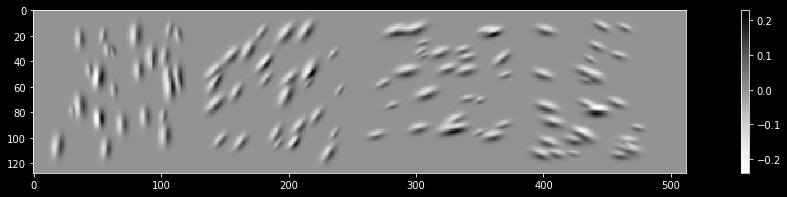

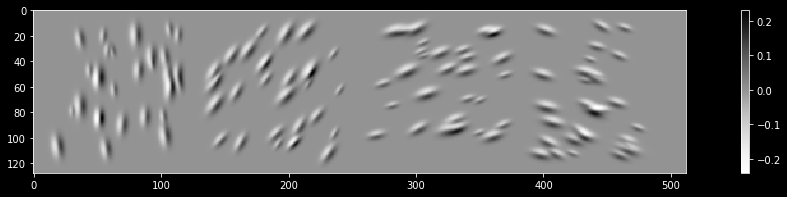

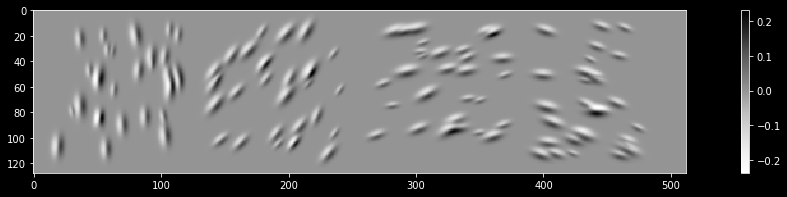

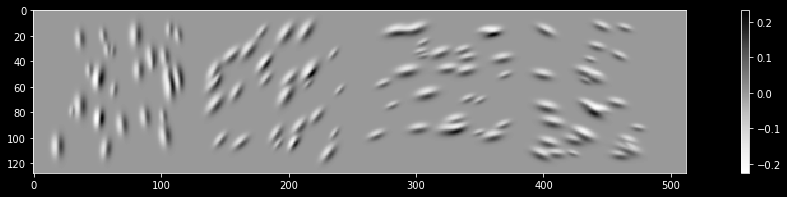

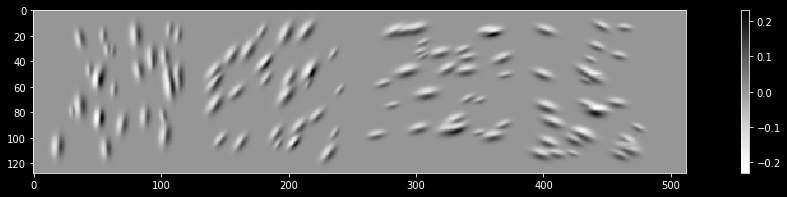

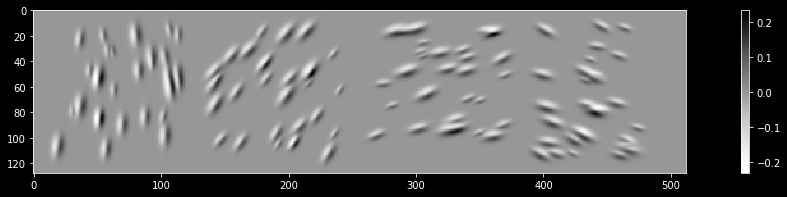

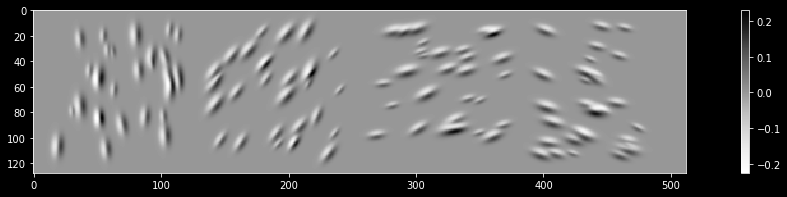

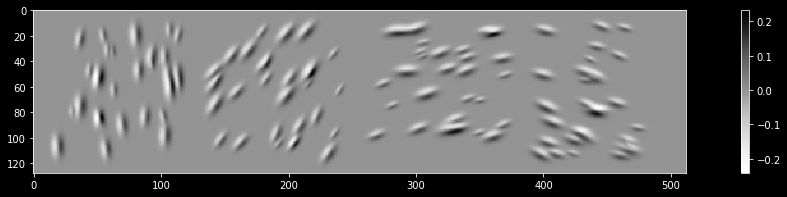

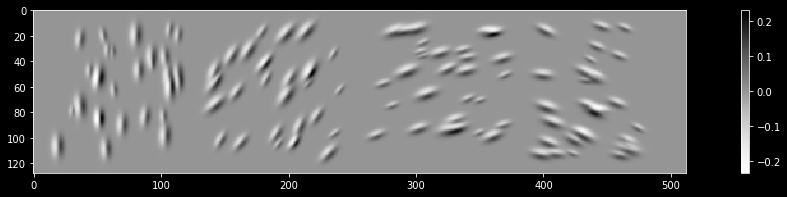

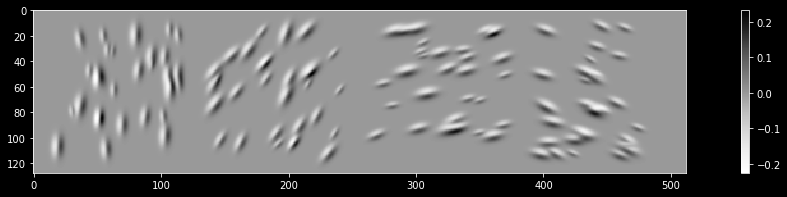

In [644]:
i = 0
for G in gabor_dl:    
    plt.figure(figsize=(20, 3))
    plt.imshow(np.concatenate(G.numpy()[:, 0]).T, cmap=plt.cm.Greys);
    plt.colorbar()
    i += 1
    if i == 12:
        break